# Does symbolic regression depend on dynamical properties?
The dysts database contains over 100 chaotic systems, and we will investigate a subset of the systems that are polynomially nonlinear, with highest polynomial degree <= 4. All of the following 70 systems are bounded and exhibit strange attractors.

Dynamical properties of interest include:
1. Level of chaos, as measured by the largest Lyapunov exponent,
2. Scale separation, as measured by the ratio of the "dominant" timescale to the "minimum significant" time scale (see William Gilpin's dysts paper),
3. Syntactical complexity, as measured by the description length metric,
4. Degree of nonlinearity, measured as the highest polynomially nonlinearity appearing in the governing equations. 

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.metrics import mean_squared_error
from dysts.base import make_trajectory_ensemble
from dysts.base import get_attractor_list
import dysts.flows as flows
import dysts.datasets as datasets
from dysts.equation_utils import *
import time
from utils import *

import pysindy as ps

# Chaotic System Initialization

This experiment include 70 chaotic, polynomially nonlinear systems provided by the database from William Gilpin. "Chaos as an interpretable benchmark for forecasting and data-driven modelling" Advances in Neural Information Processing Systems (NeurIPS) 2021 https://arxiv.org/abs/2110.05266.

In [2]:
t1 = time.time()

# Arneodo does not have the Lyapunov spectrum calculated so omit it.
# HindmarshRose and AtmosphericRegime seem to be poorly sampled
# by the dt and dominant time scales used in the database, so we omit them.
systems_list = [
                "Aizawa", "Bouali2", 
                "GenesioTesi", "HyperBao", "HyperCai", "HyperJha", 
                "HyperLorenz", "HyperLu", "HyperPang", "Laser",
                "Lorenz", "LorenzBounded", "MooreSpiegel", "Rossler", "ShimizuMorioka",
                "HenonHeiles", "GuckenheimerHolmes", "Halvorsen", "KawczynskiStrizhak",
                "VallisElNino", "RabinovichFabrikant", "NoseHoover", "Dadras", "RikitakeDynamo",
                "NuclearQuadrupole", "PehlivanWei", "SprottTorus", "SprottJerk", "SprottA", "SprottB",
                "SprottC", "SprottD", "SprottE", "SprottF", "SprottG", "SprottH", "SprottI", "SprottJ",
                "SprottK", "SprottL", "SprottM", "SprottN", "SprottO", "SprottP", "SprottQ", "SprottR",
                "SprottS", "Rucklidge", "Sakarya", "RayleighBenard", "Finance", "LuChenCheng",
                "LuChen", "QiChen", "ZhouChen", "BurkeShaw", "Chen", "ChenLee", "WangSun", "DequanLi",
                "NewtonLiepnik", "HyperRossler", "HyperQi", "Qi", "LorenzStenflo", "HyperYangChen", 
                "HyperYan", "HyperXu", "HyperWang", "Hadley",
               ]
alphabetical_sort = np.argsort(systems_list)
systems_list = np.array(systems_list)[alphabetical_sort]

# attributes list
attributes = [
    "maximum_lyapunov_estimated",
    "lyapunov_spectrum_estimated",
    "embedding_dimension",
    "parameters",
    "dt",
    "hamiltonian",
    "period",
    "unbounded_indices"
]

# Get attributes
all_properties = dict()
for i, equation_name in enumerate(systems_list):
    eq = getattr(flows, equation_name)()
    attr_vals = [getattr(eq, item, None) for item in attributes]
    all_properties[equation_name] = dict(zip(attributes, attr_vals))
    
n = 1000
pts_per_period = 100
n_trajectories = 5
# Get training and testing trajectories for all the experimental systems 
all_sols_train, all_t_train, all_sols_test, all_t_test = load_data(
    systems_list, all_properties, 
    n=n, pts_per_period=pts_per_period,
    random_bump=False,
    n_trajectories=n_trajectories
)
        
t2 = time.time()
print('Took ', t2 - t1, ' seconds to load the systems')

0 Aizawa(name='Aizawa', params={'a': 0.95, 'b': 0.7, 'c': 0.6, 'd': 3.5, 'e': 0.25, 'f': 0.1}, random_state=None)
1 Bouali2(name='Bouali2', params={'a': 3.0, 'b': 2.2, 'bb': 0, 'c': 0, 'g': 1.0, 'm': -0.0026667, 'y0': 1.0}, random_state=None)
2 BurkeShaw(name='BurkeShaw', params={'e': 13, 'n': 10}, random_state=None)
3 Chen(name='Chen', params={'a': 35, 'b': 3, 'c': 28}, random_state=None)
4 ChenLee(name='ChenLee', params={'a': 5, 'b': -10, 'c': -0.38}, random_state=None)
5 Dadras(name='Dadras', params={'c': 2.0, 'e': 9.0, 'o': 2.7, 'p': 3.0, 'r': 1.7}, random_state=None)
6 DequanLi(name='DequanLi', params={'a': 40, 'c': 1.833, 'd': 0.16, 'eps': 0.65, 'f': 20, 'k': 55}, random_state=None)
7 Finance(name='Finance', params={'a': 0.001, 'b': 0.2, 'c': 1.1}, random_state=None)
8 GenesioTesi(name='GenesioTesi', params={'a': 0.44, 'b': 1.1, 'c': 1}, random_state=None)
9 GuckenheimerHolmes(name='GuckenheimerHolmes', params={'a': 0.4, 'b': 20.25, 'c': 3, 'd': 1.6, 'e': 1.7, 'f': 0.44}, random_

# Calculate the true coefficients
Function from utils.py file reads in all the dysts database functions defining the systems of ODEs, and extracts all the coefficients.

In [3]:
num_attractors = len(systems_list)

lyap_list = []
dimension_list = []
param_list = []

# Calculate various definitions of scale separation
scale_list_avg = []
scale_list = []
linear_scale_list = []

for system in systems_list:
    lyap_list.append(all_properties[system]['maximum_lyapunov_estimated'])
    dimension_list.append(all_properties[system]['embedding_dimension'])
    param_list.append(all_properties[system]['parameters'])
    
    # Ratio of dominant (average) to smallest timescales
    scale_list_avg.append(all_properties[system]['period'] / all_properties[system]['dt'])


true_coefficients = make_dysts_true_coefficients(systems_list, 
                                                 all_sols_train, 
                                                 dimension_list, 
                                                 param_list)

weak_form = False

# Need to reorder the coefficients if using the weak form to compare with analytic!
if weak_form:
    reorder1 = np.array([ 0,  1,  2,  3,  4,  7,  9,  5,  6,  8, 10, 16, 19, 11, 12, 17, 13,
           15, 18, 14, 20, 30, 34, 21, 22, 31, 26, 29, 33, 23, 25, 32, 27, 28,
           24], dtype=int)
    reorder2 = np.array([ 0,  1,  2,  3,  4,  5,  9, 12, 14,  6,  7,  8, 10, 11, 13, 15, 25,
           31, 34, 16, 17, 18, 26, 27, 32, 19, 22, 24, 28, 30, 33, 20, 21, 23,
           29, 35, 55, 65, 69, 36, 37, 38, 56, 57, 66, 45, 51, 54, 61, 64, 68,
           39, 42, 44, 58, 60, 67, 46, 47, 52, 62, 48, 50, 53, 63, 40, 41, 43,
           59, 49], dtype=int)

    for i, system in enumerate(systems_list):
        if dimension_list[i] == 3:
            true_coefficients[i] = true_coefficients[i][:, reorder1]
        else:
            true_coefficients[i] = true_coefficients[i][:, reorder2]

nonlinearities = nonlinear_terms_from_coefficients(true_coefficients)
count = 0

for i, system in enumerate(systems_list):
    linear_coefs = true_coefficients[i][:, :dimension_list[i]] 
    max_linear = np.max(abs(linear_coefs))
    min_linear = np.min(abs(linear_coefs[linear_coefs != 0.0]))
    linear_scale_list.append(max_linear / min_linear)
    sorted_spectrum = np.sort((np.array(all_properties[system]['lyapunov_spectrum_estimated'])))
    lambda_max = sorted_spectrum[-1]
    lambda_min = sorted_spectrum[0]
    if np.all(np.array(all_properties[system]['lyapunov_spectrum_estimated'][0:2]) > 0.0):
        count += 1
    scale_list.append(lambda_max / lambda_min)

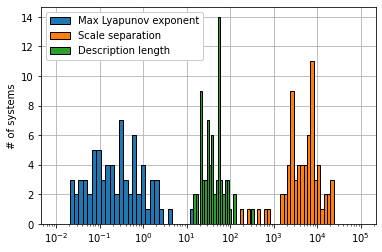

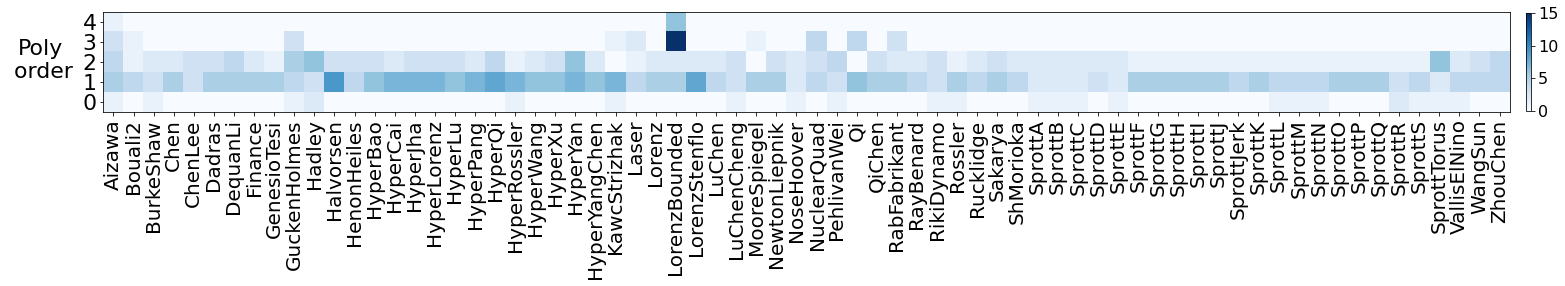

In [4]:
from matplotlib.colors import LogNorm

medl_list = compute_medl(systems_list, param_list)

systems_list_cleaned = []
for i, system in enumerate(systems_list):
    if system == "GuckenheimerHolmes":
        systems_list_cleaned.append("GuckenHolmes")
    elif system == "NuclearQuadrupole":
        systems_list_cleaned.append("NuclearQuad")
    elif system == "RabinovichFabrikant":
        systems_list_cleaned.append("RabFabrikant")
    elif system == "KawczynskiStrizhak":
        systems_list_cleaned.append("KawcStrizhak")
    elif system == "RikitakeDynamo":
        systems_list_cleaned.append("RikiDynamo")
    elif system == "ShimizuMorioka":
        systems_list_cleaned.append("ShMorioka")
    elif system == "HindmarshRose":
        systems_list_cleaned.append("Hindmarsh")
    elif system == "RayleighBenard":
        systems_list_cleaned.append("RayBenard")
    else:
        systems_list_cleaned.append(system)
    
plt.figure()
medl_levels = np.logspace(1, 3, 40)
lyap_levels = np.logspace(-2, 2, 40)
scale_levels = np.logspace(2, 5, 40)

plt.hist(lyap_list, bins=lyap_levels, ec='k')
plt.hist(scale_list_avg, bins=scale_levels, ec='k')
plt.hist(medl_list, bins=medl_levels, ec='k')
plt.xlabel('')
plt.ylabel('# of systems')
plt.legend(['Max Lyapunov exponent', 'Scale separation', 'Description length'],
           framealpha=1.0)
plt.xscale('log')
plt.grid(True)
ax = plt.gca()
ax.set_axisbelow(True)
plt.savefig('metrics.pdf')

plt.figure(figsize=(30, 6))
plt.imshow(nonlinearities.T, aspect='equal', origin='lower', cmap='Blues')
plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=20)
ax = plt.gca()
plt.xlim(-0.5, num_attractors - 0.5)
ax.set_xticklabels(np.array(systems_list_cleaned))
plt.yticks(np.arange(5), fontsize=22)
plt.colorbar(shrink=0.3, pad=0.01).ax.tick_params(labelsize=16)
plt.ylabel('Poly\n order', rotation=0, fontsize=22)
ax.yaxis.set_label_coords(-0.045, 0.3)
plt.savefig('nonlinearity.pdf')

## Trajectory Visualization
Visualizing the training and testing trajectories helps us verify if the time series data is coming from the strange attractors or from transients in the evolution.

Took  5.0225510597229  seconds to plot the systems


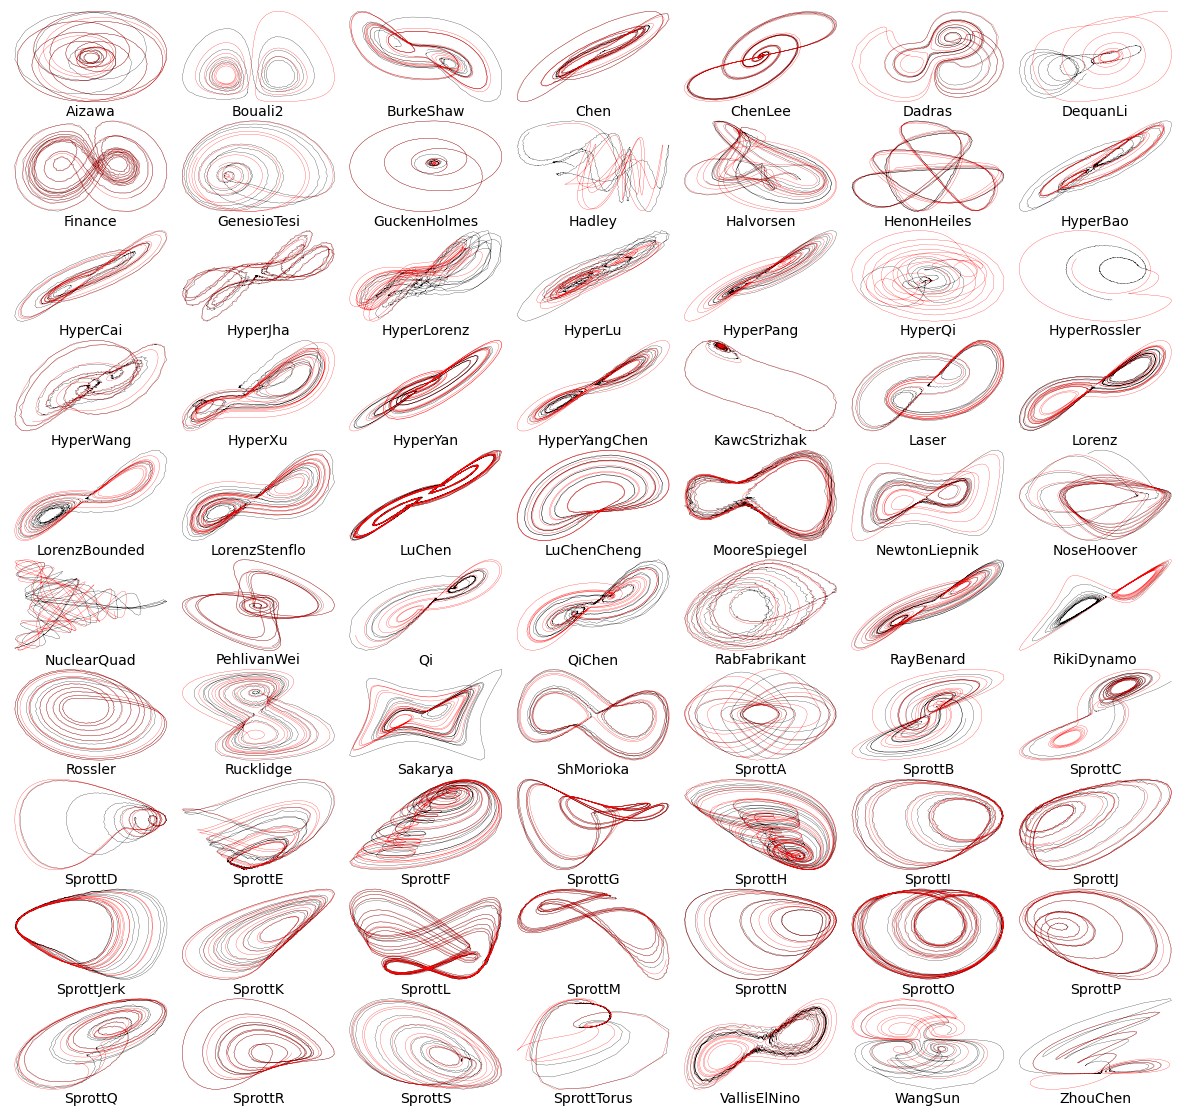

In [5]:
t1 = time.time()

# add some Gaussian noise
noise_level = 0.0

# Plot the training and testing trajectories for all the chaotic systems
num_cols = 7
num_rows = int(np.ceil(num_attractors / num_cols))
fig = plt.figure(figsize=(num_cols * 3, num_rows * 2))

gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.0, hspace=0.1) 

for i, attractor_name in enumerate(systems_list):
    
    x_train = all_sols_train[attractor_name][0]
    rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
    x_train += np.random.normal(0, rmse / 100.0, x_train.shape)  # plot with 1% noise
    x_test = all_sols_test[attractor_name][0]
    t_train = all_t_train[attractor_name]
    t_test = all_t_test[attractor_name]
    
    plt.subplot(gs[i])
    plt.plot(x_train[:, 0], x_train[:, 1], 'k', linewidth=0.25)
    plt.plot(x_test[:, 0], x_test[:, 1], 'r', linewidth=0.25)
    plt.title(systems_list_cleaned[i], y=-0.15, fontsize=14)
    plt.gca().axis('off')
            
t2 = time.time()
print('Took ', t2 - t1, ' seconds to plot the systems')
plt.show()

Took  3.7885420322418213  seconds to plot the systems


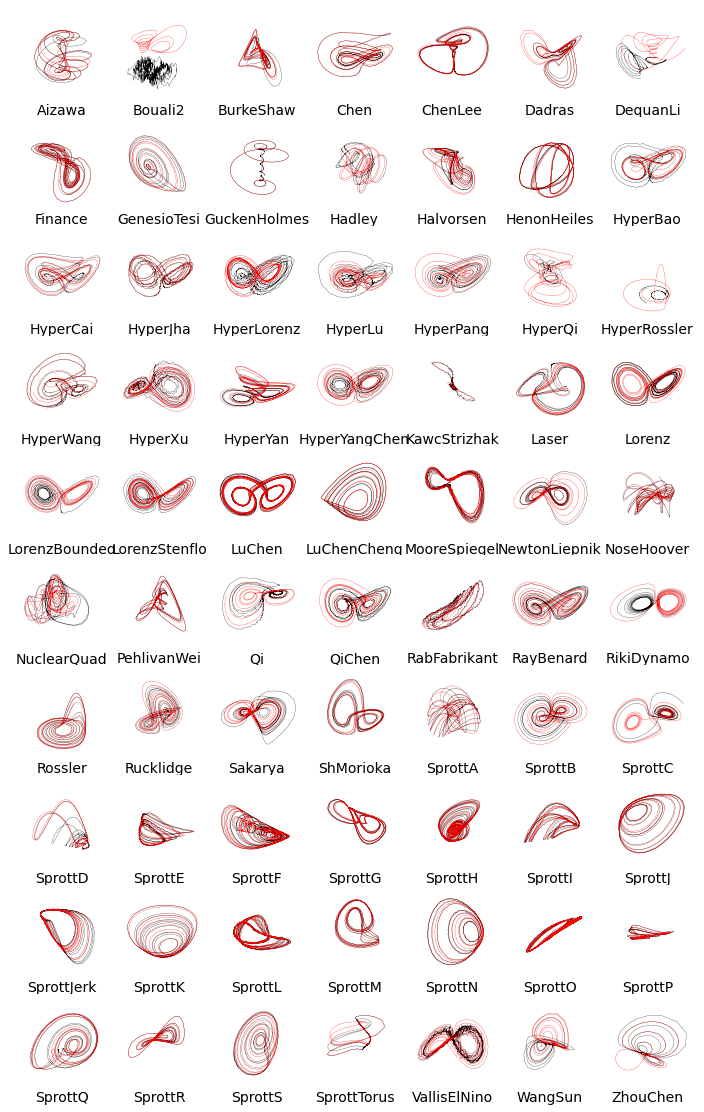

In [6]:
t1 = time.time()

# add some Gaussian noise
noise_level = 0.0

# Plot the training and testing trajectories for all the chaotic systems
num_cols = 7
num_rows = int(np.ceil(num_attractors / num_cols))
fig = plt.figure(figsize=(num_cols * 2, num_rows * 2))

gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=-0.5, hspace=0.1) 

for i, attractor_name in enumerate(systems_list):
    
    x_train = all_sols_train[attractor_name][0]
    rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
    x_train += np.random.normal(0, rmse / 100.0, x_train.shape)  # plot with 1% noise
    x_test = all_sols_test[attractor_name][0]
    t_train = all_t_train[attractor_name]
    t_test = all_t_test[attractor_name]
    
    ax = fig.add_subplot(gs[i], projection='3d')
    ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], 'k', linewidth=0.25)
    ax.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'r', linewidth=0.25)
    plt.title(systems_list_cleaned[i], y=-0.15, fontsize=14)
    plt.gca().axis('off')
            
t2 = time.time()
print('Took ', t2 - t1, ' seconds to plot the systems')
plt.show()

# Use the RMSE errors of $\dot{x}$ on a testing trajectory to guide a hyperparameter scan for the best threshold to use in the STLSQ algorithm. 
This uses a modified "Rudy algorithm" where the best model at each iteration is the one that minimizes the sum of the normalized RMSE error of $\dot{x}$ on a test trajectory and the number of nonzero terms * the l0 penalty value. Note that some models will fail to produce correct models (as measured against the true coefficients) even in the noiseless case, unless the data is well sampled. We will use the results of this scan to run ensembling SINDy, which will allow us to conclude about the effects of scale separation. 

In [7]:
t1 = time.time()

# Note, defaults to using the AIC to decide the Pareto-optimal model
n_models = 10
(xdot_rmse_errors, xdot_coef_errors, AIC, x_dot_tests, x_dot_test_preds,
predicted_coefficients, best_threshold_values, 
best_normalized_coef_errors, models, condition_numbers) = Pareto_scan_ensembling(
    systems_list, dimension_list, true_coefficients, 
    all_sols_train, all_t_train, all_sols_test, all_t_test, 
    normalize_columns=False,  # whether to normalize the SINDy matrix
    error_level=noise_level,  # amount of noise to add to the training data
    n_models=n_models,  # number of models to train using EnsemblingOptimizer functionality
    n_subset=int(0.5 * len(all_t_train['HyperBao'][0])),  # subsample 50% of the training data for each model
    replace=False,  # Do the subsampling without replacement
    weak_form=weak_form  # use the weak form or not
)
            
t2 = time.time()
print('Total time to compute = ', t2 - t1, ' seconds')
print('Condition numbers = ', condition_numbers)


0  /  70 , System =  Aizawa
1  /  70 , System =  Bouali2
2  /  70 , System =  BurkeShaw
3  /  70 , System =  Chen
4  /  70 , System =  ChenLee
5  /  70 , System =  Dadras
6  /  70 , System =  DequanLi
7  /  70 , System =  Finance
8  /  70 , System =  GenesioTesi
9  /  70 , System =  GuckenheimerHolmes
10  /  70 , System =  Hadley
11  /  70 , System =  Halvorsen
12  /  70 , System =  HenonHeiles
13  /  70 , System =  HyperBao
14  /  70 , System =  HyperCai
15  /  70 , System =  HyperJha
16  /  70 , System =  HyperLorenz
17  /  70 , System =  HyperLu
18  /  70 , System =  HyperPang
19  /  70 , System =  HyperQi
20  /  70 , System =  HyperRossler
21  /  70 , System =  HyperWang
22  /  70 , System =  HyperXu
23  /  70 , System =  HyperYan
24  /  70 , System =  HyperYangChen
25  /  70 , System =  KawczynskiStrizhak
26  /  70 , System =  Laser
27  /  70 , System =  Lorenz
28  /  70 , System =  LorenzBounded
29  /  70 , System =  LorenzStenflo
30  /  70 , System =  LuChen
31  /  70 , System =

### Normalized Error
Below, we can plot the individual coefficient errors for every system (but this is a lot of information and plots!) and we can plot the total normalized coefficient errors, RMSE errors, and best thresholds for each system, along with a linear fit (on a semi-log plot, so really an exponential fit) on the coefficient error. The fit indicates that scale separation and the invariant manifolds matter!

In [8]:
avg_rmse_error = np.zeros(num_attractors)
std_rmse_error = np.zeros(num_attractors)
coef_avg_error = np.zeros((num_attractors, n_models))
best_thresholds = np.zeros(num_attractors)
for i, attractor_name in enumerate(systems_list):
    for j in range(n_models):
        coef_avg_error[i, j] = total_coefficient_error_normalized(
            true_coefficients[i],
            np.array(predicted_coefficients[attractor_name])[0, j, :, :]
        )
    avg_rmse_error[i] = np.mean(np.ravel(abs(np.array(xdot_rmse_errors[attractor_name]))))
    std_rmse_error[i] = np.std(np.ravel(abs(np.array(xdot_rmse_errors[attractor_name]))))
    best_thresholds[i] = best_threshold_values[attractor_name][0]

if weak_form:
    # define data structure for records
    rmse_error_strong = {}

    for system in systems_list:
        rmse_error_strong[system] = list()

    ### Compute RMSE errors using a non-weak model, since currently the RMSE error
    # with the weak form is the weak version of it.
    reorder1 = np.array([ 0,  1,  2,  3,  4,  7,  8,  5,  9,  6, 10, 13, 14, 16, 19, 17, 11,
           15, 18, 12, 20, 23, 24, 29, 34, 30, 26, 32, 33, 27, 21, 25, 31, 28,
           22], dtype=int)
    reorder2 = np.array([ 0,  1,  2,  3,  4,  5,  9, 10, 11,  6, 12, 13,  7, 14,  8, 15, 19,
           20, 21, 25, 31, 32, 26, 33, 27, 16, 22, 23, 28, 34, 29, 17, 24, 30,
           18, 35, 39, 40, 41, 51, 65, 66, 52, 67, 53, 45, 57, 58, 61, 69, 62,
           46, 59, 63, 47, 36, 42, 43, 54, 68, 55, 48, 60, 64, 49, 37, 44, 56,
           50, 38], dtype=int)
    models_strong = []
    for i, attractor_name in enumerate(systems_list):
        x_test_list = []
        t_test_list = []
        for j in range(n_trajectories):
            x_test_list.append(all_sols_test[attractor_name][j])
            t_test_list.append(all_t_test[attractor_name][j])
        poly_lib = ps.PolynomialLibrary(degree=4)
        if dimension_list[i] == 3:
            feature_names = ["x", "y", "z"]
        else:
            feature_names = ["x", "y", "z", "w"]
        optimizer = ps.STLSQ(
            threshold=0.0,
            alpha=1e-5,
            max_iter=100,
            normalize_columns=False,
            ridge_kw={"tol": 1e-10},
        )
        model = ps.SINDy(
            feature_library=poly_lib,
            optimizer=optimizer,
            feature_names=feature_names,
        )
        model.fit(np.zeros(all_sols_train[attractor_name][0].shape))
        coef_temp = np.mean(np.array(predicted_coefficients[attractor_name])[0, :, :, :], axis=0)
        if dimension_list[i] == 3:
            model.optimizer.coef_ = coef_temp[:, reorder1]
        else:
            model.optimizer.coef_ = coef_temp[:, reorder2]
        model.print()
        models_strong.append(model)
        x_dot_test = model.differentiate(x_test_list, t=t_test_list, multiple_trajectories=True)
        x_dot_test_pred = model.predict(x_test_list, multiple_trajectories=True)
        rmse_error_strong[attractor_name].append(normalized_RMSE(
            np.array(x_dot_test).reshape(n_trajectories * n, dimension_list[i]),
            np.array(x_dot_test_pred).reshape(n_trajectories * n, dimension_list[i]),
            )
                                            )

5.73981934701631e-07 0.022758775134861218 0.028296053217155163 0.8161298058777533 2.4589175783046e-06
R^2 value for RMSE error =  0.000800666627668077
R^2 value for coef error =  0.022185108059059492
-0.00020606532146423098 0.026590158940529292 -0.003374154080891723 0.9778839058886792 0.0074059891519430605
R^2 value for RMSE error =  1.1384915761598268e-05
R^2 value for coef error =  0.000670284335837622
0.00028541072366165127 0.012127508938704857 0.11253148550110798 0.3536648871336705 0.00030561482032486967
R^2 value for RMSE error =  0.012663335229086074
R^2 value for coef error =  0.017439204724920363
-3.5210705339340926e-05 0.02711369148007643 -0.00406067426310494 0.9733855625786503 0.0010515224155788387
R^2 value for RMSE error =  1.6489075471042848e-05
R^2 value for coef error =  0.00821962134078837


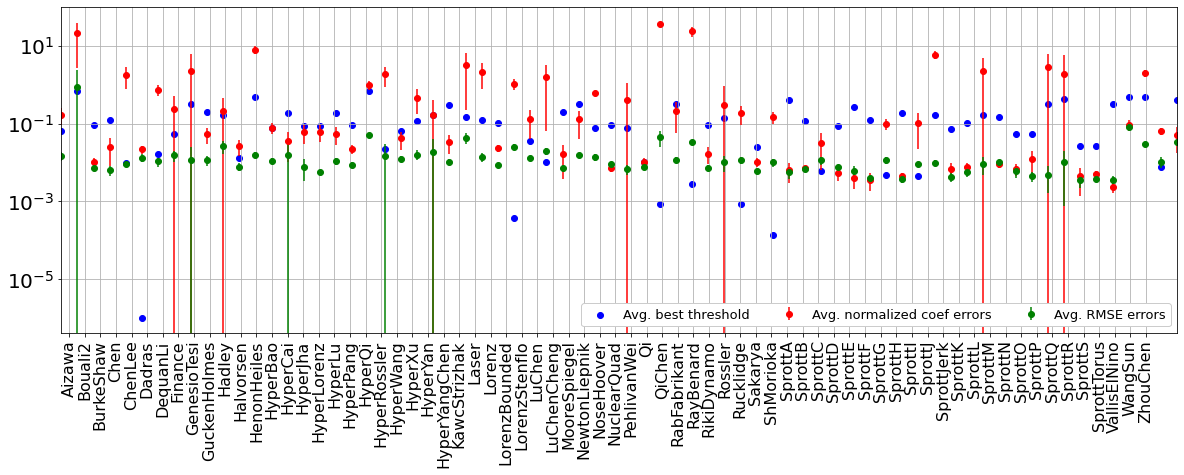

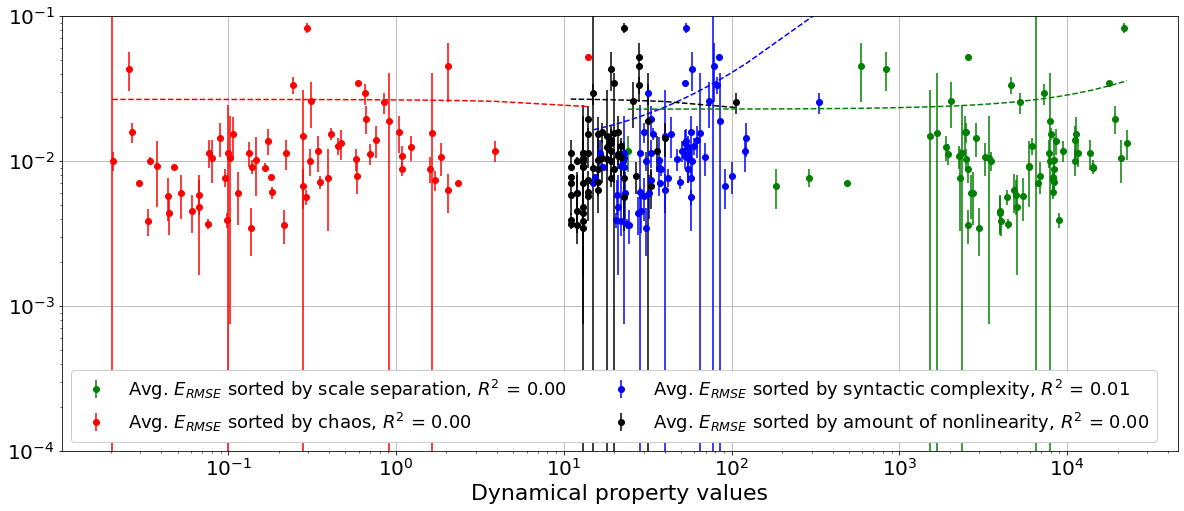

In [9]:
plt.figure(figsize=(20, 6))
    
plt.errorbar(
    np.linspace(-0.5, num_attractors + 1, num_attractors),
    np.mean(coef_avg_error, axis=-1),
    np.std(coef_avg_error, axis=-1),
    fmt="ro",
    label="Avg. normalized coef errors",
)
plt.errorbar(
    np.linspace(-0.5, num_attractors + 1, num_attractors),
    avg_rmse_error,
    std_rmse_error,
    fmt="go",
    label="Avg. RMSE errors",
)
plt.scatter(
    np.linspace(-0.5, num_attractors + 1, num_attractors), 
    best_thresholds, c="b", marker='o',
    label="Avg. best threshold"
)
plt.grid(True)
plt.yscale("log")
plt.legend(
    #["10% normalized error", "$E_{coef}$", "$E_{RMSE}$", "Optimal threshold"],
    framealpha=1.0,
    ncol=4,
    fontsize=13,
)
ax = plt.gca()
plt.xticks(np.arange(num_attractors), rotation="vertical", fontsize=16)
plt.xlim(-0.5, num_attractors + 1)
ax.set_xticklabels(np.array(systems_list_cleaned))
plt.yticks(fontsize=20)
plt.savefig("model_summary_zeroNoise.pdf", bbox_inches = "tight")

# compute the unsorted errors
cerrs = np.mean(coef_avg_error, axis=-1)

# Repeat the plot, but reorder things by the amount of scale separation
scale_sort = np.argsort(scale_list_avg)
scale_list_sorted = np.sort(scale_list_avg)

from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)
print(slope, intercept, r_value, p_value, std_err)
print("R^2 value for RMSE error = ", r_value**2)
print("R^2 value for coef error = ", r_value_coef**2)

plt.figure(figsize=(20, 8))
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="go",
    label="Avg. $E_{RMSE}$ sorted by scale separation, $R^2$ = " + "{0:.2f}".format(r_value**2)
)
plt.plot(scale_list_sorted, slope * scale_list_sorted + intercept, "g--", )

### now chaos
scale_sort = np.argsort(lyap_list)
scale_list_sorted = np.sort(lyap_list)
slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)
print(slope, intercept, r_value, p_value, std_err)
print("R^2 value for RMSE error = ", r_value**2)
print("R^2 value for coef error = ", r_value_coef**2)

#plt.figure(figsize=(20, 2))
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="ro",
    label="Avg. $E_{RMSE}$ sorted by chaos, $R^2$ = " + "{0:.2f}".format(r_value**2)
)
plt.plot(scale_list_sorted, slope * scale_list_sorted + intercept, "r--", )

### now description length
scale_sort = np.argsort(medl_list)
scale_list_sorted = np.array(np.sort(medl_list), dtype=float)
slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)
print(slope, intercept, r_value, p_value, std_err)
print("R^2 value for RMSE error = ", r_value**2)
print("R^2 value for coef error = ", r_value_coef**2)

#plt.figure(figsize=(20, 2))
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="bo",
    label="Avg. $E_{RMSE}$ sorted by syntactic complexity, $R^2$ = " + "{0:.2f}".format(r_value**2)
)
plt.plot(scale_list_sorted, slope * scale_list_sorted + intercept, "b--", )

### now amount of nonlinearity
weights = np.ones(nonlinearities.shape)
weights[:, 1] = 2
weights[:, 2] = 3
weights[:, 3] = 4
weights[:, 4] = 5
nonlinear_sum = np.sum(weights * nonlinearities, axis=1)
scale_sort = np.argsort(nonlinear_sum)
scale_list_sorted = np.array(np.sort(nonlinear_sum), dtype=float)
slope, intercept, r_value, p_value, std_err = linregress(
    scale_list_sorted, avg_rmse_error[scale_sort]
)
slope_coef, intercept_coef, r_value_coef, p_value_coef, std_err_coef = linregress(
    scale_list_sorted, cerrs[scale_sort]
)
print(slope, intercept, r_value, p_value, std_err)
print("R^2 value for RMSE error = ", r_value**2)
print("R^2 value for coef error = ", r_value_coef**2)

#plt.figure(figsize=(20, 2))
plt.errorbar(
    scale_list_sorted,
    avg_rmse_error[scale_sort],
    std_rmse_error[scale_sort],
    fmt="ko",
    label="Avg. $E_{RMSE}$ sorted by amount of nonlinearity, $R^2$ = " + "{0:.2f}".format(r_value**2)
)
plt.plot(scale_list_sorted, slope * scale_list_sorted + intercept, "k--", )

plt.xscale("log")
plt.grid(True)
plt.yscale('log')
plt.legend(
    loc="lower left",
    framealpha=1.0,
    ncol=2,
    fontsize=18,
)
ax = plt.gca()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Dynamical property values', fontsize=22)
plt.ylim(1e-4, 1e-1)
plt.savefig("model_summary_zero_noise.pdf")

plt.show()

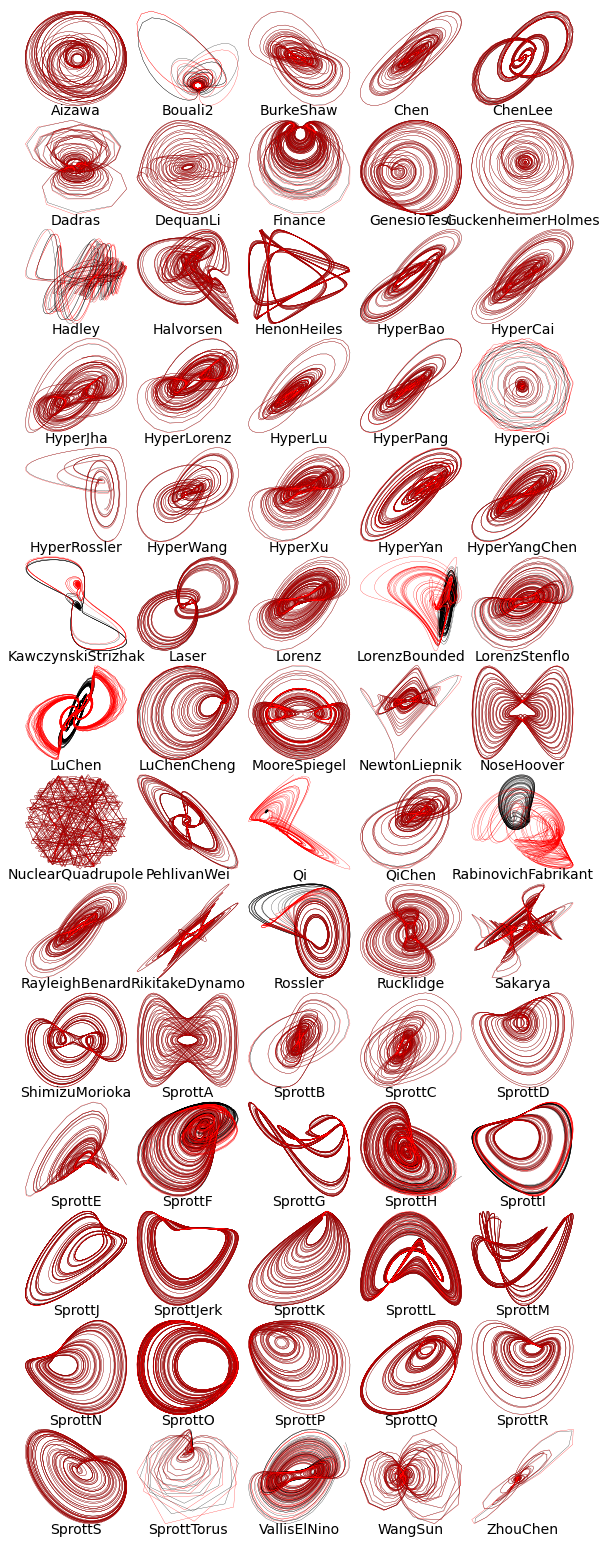

In [10]:
# Plot the true and predicted x_dot trajectories for all the chaotic systems
num_cols = 5
num_rows = int(np.ceil(len(all_sols_train) / num_cols))
fig = plt.figure(figsize=(num_cols * 2, num_rows * 2))

gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.0, hspace=0.05) 

if weak_form:
    ntime = models[i].feature_library.K
else:
    ntime = len(all_t_train['Aizawa'][0])

for i, attractor_name in enumerate(systems_list):
    x_dot_test = np.array(x_dot_tests[i]) # .reshape(n_trajectories * ntime, dimension_list[i])
    x_dot_test_pred = np.array(x_dot_test_preds[i]).reshape(n_trajectories, ntime, dimension_list[i])
    plt.subplot(gs[i])
    for j in range(n_trajectories):
        plt.plot(x_dot_test[j, :, 0], x_dot_test[j, :, 1], 'k', linewidth=0.25)
        plt.plot(x_dot_test_pred[j, :, 0], x_dot_test_pred[j, :, 1], 'r', linewidth=0.25)
    plt.title(attractor_name, y=-0.1, fontsize=14)
    plt.gca().axis('off')
    

In [ ]:
t1 = time.time()
num_test_trajectories = 2
test_trajectories, test_trajectories_time = make_test_trajectories(
    systems_list,
    all_properties,
    n=n,
    pts_per_period=pts_per_period,
    random_bump=False,
    include_transients=False,
    approximate_center=0.0,  # approximate center of the attractor
    n_trajectories=num_test_trajectories,
)

0 Aizawa(name='Aizawa', params={'a': 0.95, 'b': 0.7, 'c': 0.6, 'd': 3.5, 'e': 0.25, 'f': 0.1}, random_state=None)
1 Bouali2(name='Bouali2', params={'a': 3.0, 'b': 2.2, 'bb': 0, 'c': 0, 'g': 1.0, 'm': -0.0026667, 'y0': 1.0}, random_state=None)
2 BurkeShaw(name='BurkeShaw', params={'e': 13, 'n': 10}, random_state=None)
3 Chen(name='Chen', params={'a': 35, 'b': 3, 'c': 28}, random_state=None)
4 ChenLee(name='ChenLee', params={'a': 5, 'b': -10, 'c': -0.38}, random_state=None)
5 Dadras(name='Dadras', params={'c': 2.0, 'e': 9.0, 'o': 2.7, 'p': 3.0, 'r': 1.7}, random_state=None)
6 DequanLi(name='DequanLi', params={'a': 40, 'c': 1.833, 'd': 0.16, 'eps': 0.65, 'f': 20, 'k': 55}, random_state=None)
7 Finance(name='Finance', params={'a': 0.001, 'b': 0.2, 'c': 1.1}, random_state=None)
8 GenesioTesi(name='GenesioTesi', params={'a': 0.44, 'b': 1.1, 'c': 1}, random_state=None)
9 GuckenheimerHolmes(name='GuckenheimerHolmes', params={'a': 0.4, 'b': 20.25, 'c': 3, 'd': 1.6, 'e': 1.7, 'f': 0.44}, random_

In [ ]:
if not weak_form:
    num_cols = 5
    num_rows = int(np.ceil(len(all_sols_train) / num_cols))
    plt.figure(figsize=(num_cols * 2, num_rows * 2))
    gs = plt.matplotlib.gridspec.GridSpec(num_rows, num_cols)
    gs.update(wspace=0.0, hspace=0.0) 

    for i, attractor in enumerate(systems_list):
        print(i, attractor)
        fig = plt.subplot(gs[i])
        num_bounded = num_test_trajectories
        for j in range(num_test_trajectories):
            plt.plot(test_trajectories[attractor][:, j, 0], test_trajectories[attractor][:, j, 1], 'k') #, test_trajectories[attractor][:, j, 2], 'k')
            x0 = test_trajectories[attractor][0, j, :] + (np.random.rand(dimension_list[i]) - 0.5) * np.linalg.norm(test_trajectories[attractor][:, j, :]) / 100.0
            models[i].feature_library.fit(np.zeros(dimension_list[i]))
            x_pred = models[i].simulate(
                x0, 
                t=test_trajectories_time[attractor][:, j],
                integrator='odeint'
            )
            if np.linalg.norm(x_pred) > np.linalg.norm(test_trajectories[attractor][:, j, 0]) * 10:
                num_bounded -= 1
            else:
                plt.plot(x_pred[:, 0], x_pred[:, 1], 'b') #, alpha=(j / (n_trajectories - 1)))
            ax = plt.gca()
            fig.patch.set_facecolor('r')
        fig.patch.set_alpha(1 - (num_bounded / num_test_trajectories))
        plt.yticks([])
        plt.xticks([])
        xmax = np.max(test_trajectories[attractor][:, :, 0])
        xmin = np.min(test_trajectories[attractor][:, :, 0])
        ymax = np.max(test_trajectories[attractor][:, :, 1])
        ymin = np.min(test_trajectories[attractor][:, :, 1])
        facx = (xmax - xmin) / 3
        facy = (ymax - ymin) / 3
        plt.xlim(xmin - facx, xmax + facx)
        plt.ylim(ymin - facy, ymax + facy)
        plt.text(0.035, 0.85, systems_list_cleaned[i], transform=ax.transAxes, fontsize=12)
    plt.savefig('final_trajectories_zero_noise.pdf')
    t2 = time.time()
    print('Integrating all these new initial conditions took t = ', t2 - t1, ' seconds')